In [31]:
import os
import torch

from torchinfo import summary

import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim import SGD
import torch.nn.functional as F

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler

import numpy as np
from sklearn.metrics import roc_curve
from itertools import islice
from facenet_pytorch import InceptionResnetV1

import random

import time
import datetime


In [32]:
# Set a random seed for reproducibility
seed = 42
torch.manual_seed(seed)

# If using GPU, also set the seed for GPU
torch.cuda.manual_seed_all(seed)


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [34]:
#teacher = InceptionResnetV1(pretrained='casia-webface', classify=False, device=device) 
#teacher = InceptionResnetV1(pretrained='vggface2', classify=False, device=device)


In [35]:
model =  torch.load("KD_full_mobiFace_like_v1_1.pth") 

In [36]:
teacher_v2.to(device)

MobiFace(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (depthwise_conv): DepthwiseSeparableConv2d(
    (depthwise_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (pointwise_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): PReLU(num_parameters=1)
  )
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bottleneck_block1): BottleneckBlock(
    (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): PReLU(num_parameters=1)
    (depthwise_conv): DepthwiseSeparableConv2d(
      (depthwise_conv): Conv2d(32, 32, kernel_size=(3, 3), stri

In [37]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [38]:
# directory for test
root_dir= "C:\\Users\\mathe\\OneDrive\\Área de Trabalho\\master\\TFM\\dataset\\faces_webface_112x112\\images"


batch_size = 64

# Create ImageFolder dataset
dataset = datasets.ImageFolder(root=root_dir, transform=transform)

# Number of images for testing
num_test_images = 1000

# Total number of images
total_images = len(dataset)

# Indices of images for testing
test_indices = random.sample(range(total_images), num_test_images)

# Remaining indices for validation and training
remaining_indices = set(range(total_images)) - set(test_indices)


# Split remaining indices into validation and training sets
remaining_indices = list(remaining_indices)
random.shuffle(remaining_indices)


# Define the sizes of validation and training sets
val_size = int(0.20 * len(remaining_indices))
train_size = len(remaining_indices) - val_size

# Indices for validation and training sets
val_indices = remaining_indices[:val_size]
train_indices = remaining_indices[val_size:]


# Create Subset datasets
test_dataset = Subset(dataset, test_indices)
val_dataset = Subset(dataset, val_indices)
train_dataset = Subset(dataset, train_indices)

# Create DataLoader for training, validation, and testing
batch_size = 1  # Set batch size to 1 since we are loading images one by one
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [39]:
#teacher_v2.logits  = nn.Identity() 

In [40]:
inputs_total = []
labels_total = []
for inputs, labels in islice(train_loader,32):
    inputs, labels = inputs.to(device), labels.to(device)
    labels_total.append(labels)
    inputs_total.append(inputs)

In [41]:
teacher= teacher_v2

In [43]:
def cosine_similarity(embeddings1, embeddings2):
    dot_product = torch.dot(embeddings1, embeddings2)
    norm_embeddings1 = torch.norm(embeddings1)
    norm_embeddings2 = torch.norm(embeddings2)
    return dot_product / (norm_embeddings1 * norm_embeddings2)


embeddings = []  # List to store embeddings
labels_list = []  # List to store labels
comparison_similarity = []

teacher.eval()
for images,labels in test_loader:
    with torch.no_grad():
        outputs = teacher(images.to(device))[0]
    embeddings.append(outputs.to(device))
    labels_list.append(labels.to(device))


embeddings = torch.cat(embeddings, dim=0)
labels_list = torch.cat(labels_list, dim=0)

# Prepare labels for pairwise similarity scores (1 for same person, 0 for different people)
pairwise_labels = []
comparisons_label = []
for i, (images1, label1) in enumerate(test_loader):
    for j, (images2, label2) in enumerate(test_loader):
        if j > i:  # Only consider pairs where j > i to avoid duplicate pairs and pairs with the same image
            if label1 == label2:
                pair_label = 1  # Same person
            else:
                pair_label = 0  # Different people
            pairwise_labels.append(pair_label)
            comparisons_label.append([pair_label,label1,label2])

# Convert pairwise labels to a tensor
pairwise_labels_tensor = torch.tensor(pairwise_labels, device=device)


similarities = []
for i in range(len(embeddings)):
    for j in range(i+1, len(embeddings)):
        similarity = cosine_similarity(embeddings[i], embeddings[j])
        comparison_similarity.append([similarity,labels_list[i],labels_list[j]])
        similarities.append(similarity)

similarities_tensor = torch.tensor(similarities, device=device)

In [44]:
start_time = time.time()
formatted_time = datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')

print(formatted_time)

# Compute ROC curve

#fpr, tpr, thresholds = roc_curve(pairwise_labels_tensor.cpu().numpy(), similarities_tensor.cpu().numpy())
fpr, tpr, thresholds = roc_curve(pairwise_labels_tensor.cpu().numpy(), similarities_tensor.cpu().numpy())


# Move thresholds to CUDA

thresholds_tensor = torch.tensor(thresholds, device=device)


# Convert fpr and tpr to PyTorch tensors

fpr_tensor = torch.tensor(fpr, device=device)
tpr_tensor = torch.tensor(tpr, device=device)


# Calculate EER
eer_threshold = thresholds_tensor[torch.argmin(torch.abs(fpr_tensor - (1 - tpr_tensor)))]
eer = (fpr_tensor[torch.argmin(torch.abs(fpr_tensor - (1 - tpr_tensor)))] + (1 - tpr_tensor)[torch.argmin(torch.abs(fpr_tensor - (1 - tpr_tensor)))]) / 2

print("Equal Error Rate (EER):", eer)

2024-03-19 21:40:33
Equal Error Rate (EER): tensor(0.1140, device='cuda:0', dtype=torch.float64)


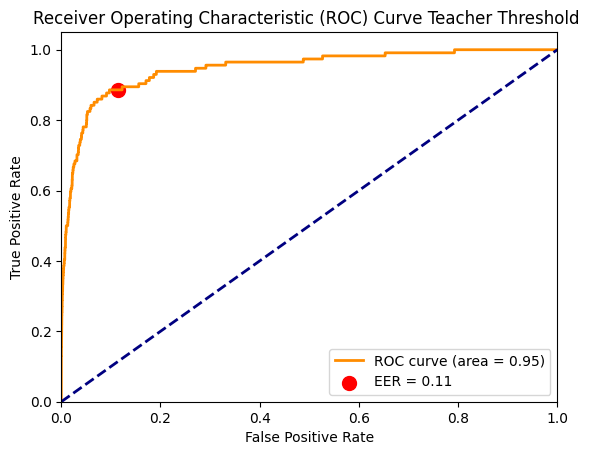

2024-03-19 21:40:40


In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Plot EER point
plt.scatter(fpr_tensor[torch.argmin(torch.abs(fpr_tensor.cpu() - (1 - tpr_tensor.cpu())))].cpu(), 
            tpr_tensor[torch.argmin(torch.abs(fpr_tensor.cpu() - (1 - tpr_tensor.cpu())))].cpu(), 
            s=100, c='red', marker='o', label='EER = %0.2f' % eer)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve Teacher Threshold ')
plt.legend(loc="lower right")
plt.show()


end_time = time.time()

formatted_time = datetime.datetime.fromtimestamp(end_time).strftime('%Y-%m-%d %H:%M:%S')
print(formatted_time)

execution_time = end_time - start_time


with open("execution_time_kd_v11.txt", "w") as file:
    file.write(f"Execution time: {execution_time} seconds")

In [ ]:
above_threshold_indices = (similarities_tensor.cpu() > eer_threshold.cpu()).nonzero()


In [ ]:
filtered_list = [pairwise_labels_tensor[idx[0]] for idx in above_threshold_indices]

In [ ]:
np.unique(torch.asarray(filtered_list,device= device).cpu(),return_counts = True)

(array([0, 1], dtype=int64), array([150636,    504], dtype=int64))

In [ ]:
embeddings[0] == embeddings[1]

tensor([False, False, False,  ..., False, False, False], device='cuda:0')